<span style="font-size:110%; text-align:left;"><b><a href="../index.html">4. Advanced Topcs</a> <a href="./index.html">2. Parametric Instabilities</a></b></span>
<br/><br/>
<span style="font-size:200%; text-align:left;"><b>Checking Finite Element Mode Normalisation</b></span>
<br/><br/>
<span style="font-size:110%; text-align:left;">Author: Daniel Brown </span>

The surface maps that you generate from your finite element modelling software must be normalised correctly for Finesse to use them. The FE software will compute the vibrational modes of your structure by generating a large matrix and computing its eigenvectors and eigenvalues, each vector providing a mode shape and each value providing the resonance frequency of the mode.

When we model parameteric instabilities with Finesse we are really asking: is there a positive feedback for a movable arbitrarily shaped surface in an interferometer. For this we need to compute two aspects:
* (1) How much does a surface move given some spatially varying force applied?
* (2) What higher order optical modes are generated by a surface moving when an optical fields is incident on it?

From the mode shape generated by a FEM software we can compute the overlap between each of the Hermite-Gaussian optical modes (HOMs) and the surface motion. A HOM with some amplitude modulation will apply a radiation pressure force on the surface, if the HOM has a good overlap with the surface the induced motion will be greater. What we need to determine is *how* much motion is induced given some amount of applied force. Please see Chapter 3 around equation 3.12 in http://etheses.bham.ac.uk/6500/ for more details on the math.

Firstly, we have to be familiar with the aspects of a modal force, modal mass, and modal amplitude. The modal force is the spatially distributed force that perfectly overlaps with the mode. The modal amplitude tells us the magnitude and phase of the surface's motion. The modal mass then tells us how much modal amplitude of motion we get per modal force applied. What is important to remember is that modal amplitude, force, and mass are not easily relatable to our usual units of meters, newtons, and kilograms. If we excite a mode and it has an amplitude of one, doesn't mean it is moving by one meter. We should also remember that a surface motion can represent many types of motion: a flat longitudinal motion of the mirror, a yaw or pitch tilt of the mirror, or some other shape such as a drumhead mode. So the unit of a modal amplitude or force isn't well defined, it just depends on what you are modelling---for example, it could be meters and newtons, or radians and newton-meter. 

Finesse uses the mode shapes to compute the inner product between the Hermite-Gaussian optical modes and a surface to compute (1) above. For this we also need to know the modal mass. However, FEM models don't return the modal mass, this is partly because it isn't a well defined quantity. There is however a relationship between the modal mass and the mode shape but it isn't unique. You can scale the modal mass by X and divide the mode shape by X and have exactly the same system. To simplify this Finesse assumes the modal mass of any surface is one. This requires your FEM software to normalise your mode shapes with **Unit Modal Mass Normalisation**.

The easiest way to check your normalisation is by comparing your FEM mode shapes against the analytic longitudinal motion of a suspended mirror. One of the low frequency modes the FEM software outputs should look flat, this is the bulk motion of the mirror. First let us load some libraries.

In [1]:
import pykat
import numpy as np
import pykat.optics.maps
import matplotlib.pyplot as plt

pykat.init_pykat_plotting()

                                              ..-
    PyKat 1.1.349         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



*Mode 1* as we will refer to it is one of the first modes that COMSOL outputs, it has a resonance of 75 mHz, which is effectively 0 for us. If we plot it we do not see much variation

/Users/adf/work/git/pykat/pykat/optics/maps.py:476: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
  cbar.set_clim(zmin, zmax)


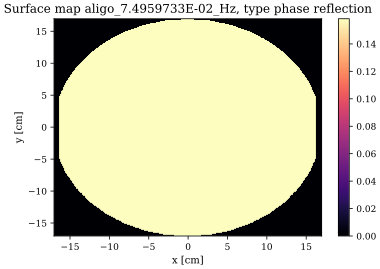

In [2]:
m = pykat.optics.maps.read_map("mode_1.map")
fig = m.plot()

We can select just the surface data by ignoring the zeros and we see the mean and standard deviation. The deviation is very small, so what we have is a flat surface motion. We also see that we have some arbitrary mean value of 0.1583...

In [3]:
surface = m.data[m.data != 0]

print(np.mean(surface), np.std(surface))

0.15836840274169176 2.540308781277266e-10


To test this map we will use two lasers incident on each side of a perfectly reflecting surface. One laser will be amplitude modulated to exert a radiation pressure force on the surface. The other laser on reflection will be phase modulated. What we will look at is the surface motion amplitude induced by our laser and the amount of modulated optical field we see on the other side. We will compare the flat surface map that we see above to the analytic solution of a mirror surface moving. If the modal normalisation has been done correctly they will give the same results!

First let's compare the modal amplitudes induced by our amplitude modulated laser beam.

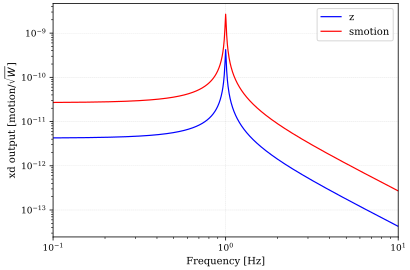

In [4]:
base = pykat.finesse.kat()
base.verbose = False

base.parse("""
l l1 1 0 n0         # Actuator beam
m m1 1 0 0 n0 n1    
l l2 1 0 n1         # Readout beam

tf tf1 1 0 p 1 100

xaxis sig f log 0.1 10 1000

fsig sig l1 amp 1 0 1

# measure the optical fields that are generated by the
# motion of the mirror
ad u00 0 0 $fs n1
ad l00 0 0 $fs n1

maxtem 0

# 5cm beam on mirror, this size w(z) needs to be picked so the
# w(z) >> dx,dy. Where dx and dy are the step sizes in the map
gauss g1 m1 n0 50m 0 

yaxis log abs:deg
""")


# First we run the analytic case where we specify that the mirror has a mass of 40kg
# and has a force to z-displacement transfer function given by tf1. So our mirror
# can move longitudinally.
kat = base.deepcopy()
kat.parse("""
attr m1 mass 40 zmech tf1
xd z m1 z
""")
out1 = kat.run()
plt.loglog(out1.x, abs(out1['z']), label="z")

# Next we run with our surface motion having the same transfer function tf1.
# Note that we don't provide any mass information here!
kat = base.deepcopy()
kat.parse("""
smotion m1 mode_1.map tf1
xd z m1 s0
""")
out2 = kat.run()
plt.loglog(out2.x, abs(out2['z']), label="smotion")

plt.ylabel("xd output [motion$/\sqrt{W}$]")
plt.xlabel("Frequency [Hz]")

plt.tight_layout()
plt.legend()

We can see we get different results! The modal amplitude isn't the same. Remember that the modal amplitudes are not in the same units. In this case we can convert our surface motion into units of meters though by taking into account the average surface shape height:

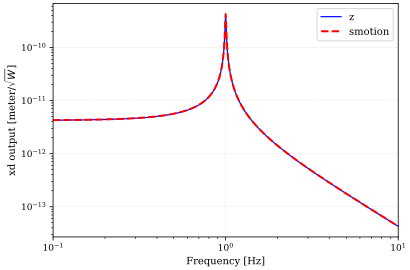

In [5]:
plt.loglog(out1.x, abs(out1['z']), label="z")
plt.loglog(out2.x, abs(out2['z'])*np.mean(surface), label="smotion", ls='--', lw=2)

plt.ylabel("xd output [meter$/\sqrt{W}$]")
plt.xlabel("Frequency [Hz]")

plt.tight_layout()
plt.legend()

And now we see a reasonable agreement. There will be small differences here due to the numerical integration procedures required by the surface motion inner products that Finesse must compute.

So we can see from this that the *mass* of the mirror is encoded in the scaling of the mode shape data we provide to Finesse. However this test just compares the motion. The better comparison are the optical fields generated by the moving surface on the opposite side to where your amplitude modulated laser is. This compares the force-to-motion and motion-to-field calculations and ensures any normalisation is correct.

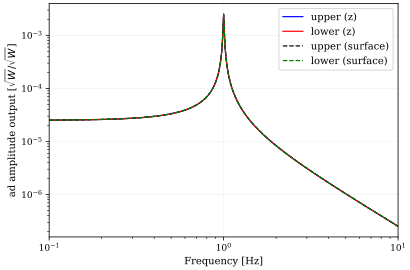

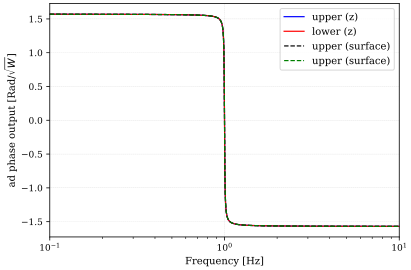

In [6]:
plt.figure()
plt.loglog(out1.x, abs(out1['u00']), label="upper (z)")               
plt.loglog(out1.x, abs(out1['l00']), label="lower (z)")               
plt.loglog(out2.x, abs(out2['u00']), label="upper (surface)", ls='--')
plt.loglog(out2.x, abs(out2['l00']), label="lower (surface)", ls='--')

plt.ylabel("ad amplitude output [$\sqrt{W}/\sqrt{W}$]")
plt.xlabel("Frequency [Hz]")

plt.tight_layout()
plt.legend()
plt.show()


plt.figure()
plt.semilogx(out1.x, np.angle(out1['u00']), label="upper (z)")
plt.semilogx(out1.x, np.angle(out1['l00']), label="lower (z)")
plt.semilogx(out2.x, np.angle(out2['u00']), label="upper (surface)", ls='--')
plt.semilogx(out2.x, np.angle(out2['l00']), label="upper (surface)", ls='--')

plt.ylabel("ad phase output [Rad$/\sqrt{W}$]")
plt.xlabel("Frequency [Hz]")

plt.tight_layout()
plt.legend()

What we see is a good agreement, with no additional factors needing to be applied. If your map normalisation is wrong then the amplitudes will not overlap!

The ratio between the your surface result and the analytic motion will tell you how much you need to scale your surfaces by to get the correct normalisation. Make sure that the mass used in the FEM model is the same as the mass used in the analytic calculation when you do this though. This scaling factor can also be applied to any of the other modes too. Ideally though you should find the correct FEM software options to use to get the unit modal mass normalisation.